# MNIST Practice 1.

In [1]:
# 1 Imports
import torch
from torchvision import datasets 
from torchvision import transforms as transform
from torch.utils.data import DataLoader
from matplotlib import pylab as plt
import torch.nn as nn
import torch.optim as optim

import tqdm
import numpy as np
import mitdeeplearning as mdl


In [2]:
# 2 Download data

traindataset = datasets.MNIST (root = './data',train=True, download= True )
testdataset = datasets.MNIST(root ='./data' , train = False, download = True)

In [3]:
# 3A Display sample image shape
transforms = transform.Compose([transform.ToTensor(),])

# Apply transforms to datasets
traindataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
testdataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

image, label = traindataset[0]
print(f"Shape of image {image.shape} , Label : {label} ")

Shape of image torch.Size([1, 28, 28]) , Label : 5 


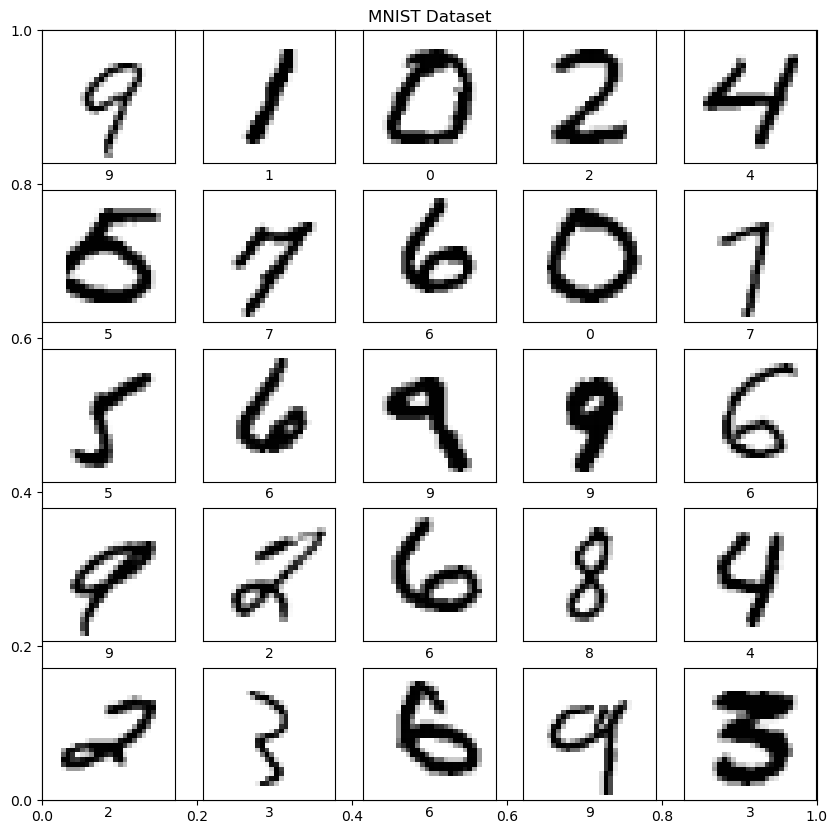

In [4]:
# 3B Display sample image with traindataset
plt.figure(figsize = (10,10))
plt.title('MNIST Dataset')

random_indx = np.random.choice(6000,25)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    indx = random_indx[i]
    image,label = traindataset[indx]
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()
    





In [5]:
#4  CNN Class
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1,32,kernel_size=3)
        self.max1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3)
        self.max2 = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*5*5,128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128,10)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max2(x)

        x = self.flatten(x)  # Added missing flatten operation
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [6]:
# 5 Institate CNN Class with sample data for checking
cnn_model = CNN().to('cuda') # Run on GPU
image, label = traindataset[0]
image = image.to('cuda').unsqueeze(0)
cnn_model(image)
print(cnn_model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
# 6 Set Training Parameters
batch_size = 64
epochs = 5
learning_rate = 1e-2

# Check for existing tqdm instances and clear them
if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()

# Create data loaders with the transformed datasets
train_loader = DataLoader(traindataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testdataset, batch_size=batch_size, shuffle=False)

# Set up loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=learning_rate)

loss_history = mdl.util.LossHistory(smoothing_factor= 0.95)
plotter = mdl.util.PeriodicPlotter(sec=2,xlabel='iterations', ylabel='loss')

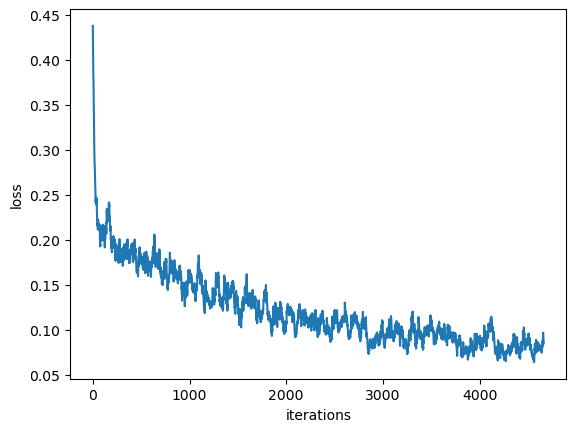

Epoch [5/5], Loss: 0.0830, Accuracy: 97.44%


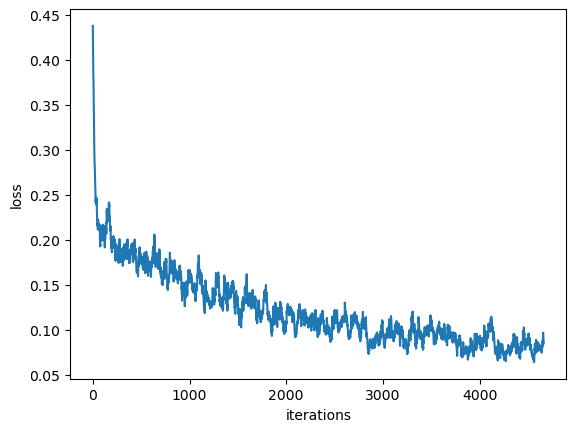

In [10]:
# 7 Training Loop
cnn_model.train()

for epoch in range(epochs):
    total_loss = 0
    total_pred = 0
    correct_pred = 0
    
    for idx, (image, label) in enumerate(train_loader):
        # Move data to GPU
        image = image.to('cuda')
        label = label.to('cuda')
        
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = cnn_model(image)

        # Loss calculation
        loss = loss_function(output, label)
        loss_value = loss.item()
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Calculate accuracy metrics
        total_loss += loss_value
        predictions = torch.argmax(output, dim=1)
        correct_pred += (predictions == label).sum().item()
        total_pred += label.size(0)
    
    # Print epoch statistics
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct_pred / total_pred
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Test Accuracy: 97.44%


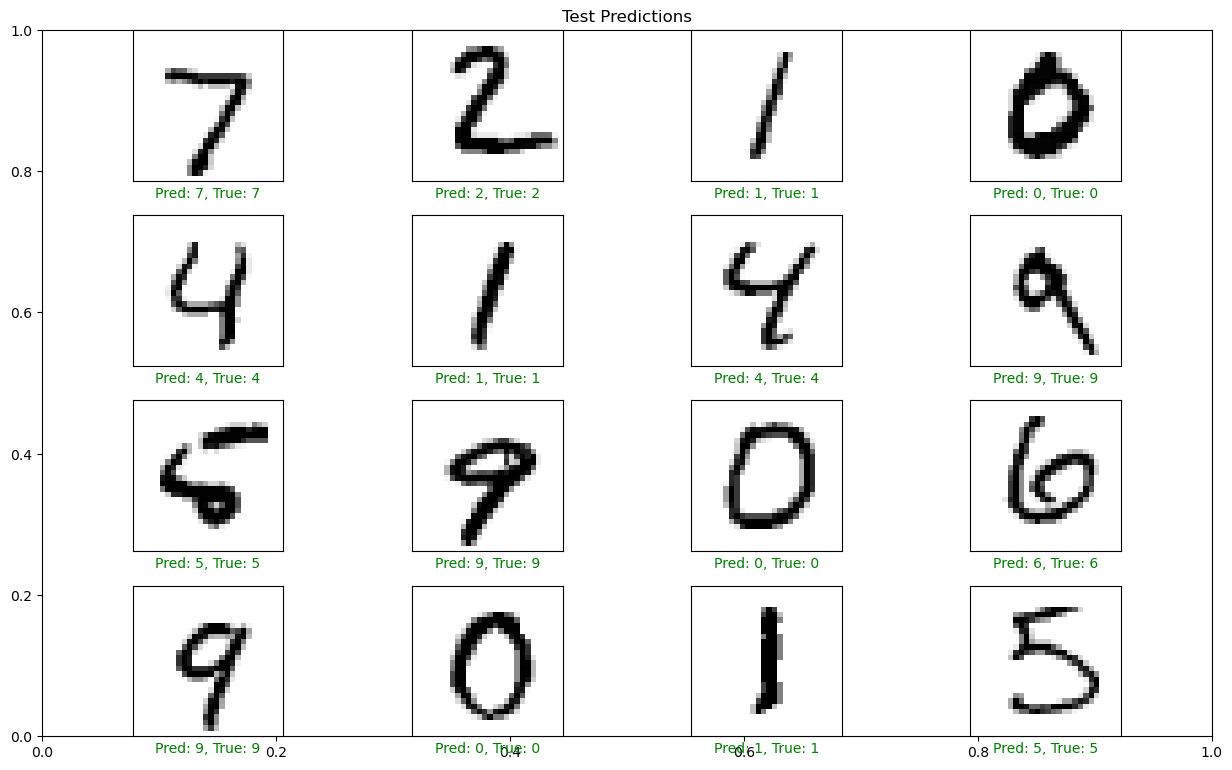

In [11]:
# 8 Test Prediction
cnn_model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to('cuda')
        labels = labels.to('cuda')
        
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Display some test predictions
plt.figure(figsize=(12, 8))
plt.title('Test Predictions')

# Get a batch of test data
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to('cuda')
labels = labels.to('cuda')

# Get predictions
with torch.no_grad():
    outputs = cnn_model(images)
    _, predicted = torch.max(outputs, 1)

# Move back to CPU for plotting
images = images.cpu()
predicted = predicted.cpu()
labels = labels.cpu()

# Display first 16 images
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].squeeze(), cmap=plt.cm.binary)
    color = 'green' if predicted[i] == labels[i] else 'red'
    plt.xlabel(f'Pred: {predicted[i]}, True: {labels[i]}', color=color)

plt.tight_layout()
plt.show()